# Data Preparation Workflow

This notebook demonstrates the data preparation workflow for the Snow Drought Index package. It covers loading data, preprocessing, station extraction and filtering, and data availability assessment.

In [4]:
# Install missing packages

%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main   # Install snowdroughtindex from the local source directory

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import sys

# Import snowdroughtindex package
#from snowdroughtindex.core import data_preparation
#from snowdroughtindex.utils import visualization, io

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'


## 1. FROSTBYTE gap filling

First, we'll load the SWE data and other required datasets.

In [5]:
# Define data paths
canswe_path = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/Paper1/inputs/CanSWE/CanSWE-CanEEN_1928-2024_v7.nc'
basin_path = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/Paper1/inputs/Elevation/'
output_path = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/Paper1/outputs/gap_filling/'

In [6]:
# Load data using the implemented functions
canswe = xr.open_dataset(canswe_path)
bow_basin = gpd.read_file(basin_path+ 'Bow_elevation_combined.shp')

In [7]:
# Extract CanSWE data for stations within the Bow basin

# Get station locations from canswe
stations_df = pd.DataFrame({
	'station_id': canswe['station_id'].values,
	'lat': canswe['lat'].values,
	'lon': canswe['lon'].values
})

# Create Point geometries for each station
stations_gdf = gpd.GeoDataFrame(
	stations_df,
	geometry=gpd.points_from_xy(stations_df['lon'], stations_df['lat']),
	crs=bow_basin.crs
)

# Find stations within any of the Bow basin polygons
stations_in_basin = stations_gdf[stations_gdf.within(bow_basin.unary_union)]

# Select these stations from canswe
bow_canswe = canswe.sel(station_id=stations_in_basin['station_id'].values)

# Convert to DataFrame
bow_canswe_df = bow_canswe.to_dataframe().reset_index()

# Save the extracted data to a CSV file
bow_canswe_df.to_csv(output_path + 'bow_canswe.csv', index=False)

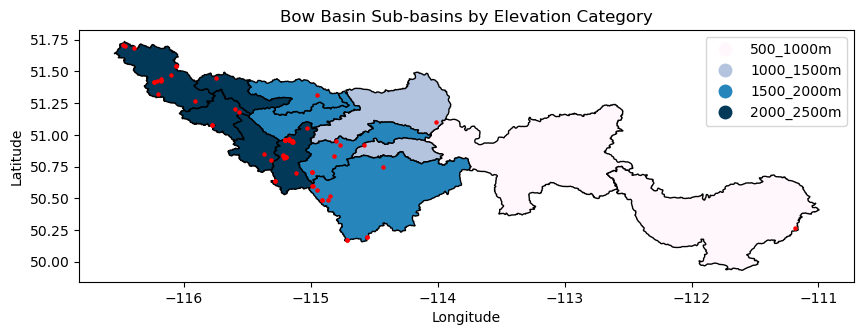

In [8]:
# Plot Bow basin polygons colored by elevation category
fig, ax = plt.subplots(figsize=(10, 10))
# plot the Bow basin polygons
# Ensure elev_class is a categorical type with desired order
bow_basin['elev_class'] = pd.Categorical(
    bow_basin['elev_class'],
    categories=['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m'],
    ordered=True
)
bow_basin.plot(ax=ax, column='elev_class', cmap='PuBu', legend=True, edgecolor='black')
# Add station points
stations_in_basin.plot(ax=ax, color='red', markersize=5, label='Stations')
ax.set_title('Bow Basin Sub-basins by Elevation Category')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig(output_path + 'bow_basin_by_elev_class.png', dpi=300)
plt.show()

FROSTBYTE workflow  (In the original workflow, SCDNA precipitation data were also used to increase the data availability. However, here I'm only using CanSWE data because I couldn't find compatible precipitation dataset for the time period 1980-2024)

In [10]:
# Set user-specified variables
flag_buffer_default, buffer_km_default = 0, 0 # buffer flag (0: no buffer around test basin, 1: buffer of value buffer_default around test basin) and buffer default value in km to be applied if flag = 1
month_start_water_year_default, day_start_water_year_default = 10, 1  # water year start
month_end_water_year_default, day_end_water_year_default = 9, 30  # water year end
min_obs_corr_default = 3 # the minimum number of overlapping observations required to calculate the correlation between 2 stations
min_obs_cdf_default = 10 # the minimum number of observations required to calculate a station's cdf
min_corr_default = 0.6 # the minimum correlation value required for donor stations to be selected
window_days_default = 7 # the number of days used on either side of the infilling date for gap filling calculations
min_obs_KGE_default = 3 # the minimum number of observations required to calculate the KGE''
max_gap_days_default = 15  # max. number of days for gaps allowed in the daily SWE data for the linear interpolation
artificial_gap_perc_default = 100 # the percentage of observations to remove during the artificial gap filling for each station & month's first day
iterations_default = 1 # the number of times we repeat the artificial gap filling
artificial_gap_filling_flag = 0 # indicates whether artificial gap filling is performed (1) or not (0)
artificial_gap_filling_basins = ['all'] # a list of the basin(s) to run the gap filling for. To include all basins simply write 'all'

## 2. Data Preprocessing

Next, we'll preprocess the data to prepare it for analysis.

In [ ]:
# Preprocess SWE data
swe_processed = data_preparation.preprocess_swe(swe_data)

# Preprocess precipitation data
precip_processed = data_preparation.preprocess_precip(precip_data)

# Convert to GeoDataFrame for spatial operations
swe_gdf = data_preparation.convert_to_geodataframe(swe_processed)

## 3. Station Extraction and Filtering

Now, we'll extract stations within the basin of interest.

In [ ]:
# Define basin ID
basin_id = 'example_basin'  # Replace with actual basin ID

# Extract stations within the basin
stations_in_basin, basin_buffer = data_preparation.extract_stations_in_basin(swe_gdf, basin_data, basin_id)

# Filter data for stations in the basin
station_ids = stations_in_basin['station_id'].tolist()
swe_basin = data_preparation.filter_stations(swe_data, station_ids)

## 4. Data Availability Assessment

Finally, we'll assess the availability of data for the stations in the basin.

In [ ]:
# Assess data availability
availability = data_preparation.assess_data_availability(swe_basin)

# Visualize data availability (assuming this function exists in the visualization module)
# visualization.plot_data_availability(availability)

# Alternative: Basic visualization using matplotlib
plt.figure(figsize=(10, 6))
availability.plot(cmap='viridis')
plt.colorbar(label='Data Availability (%)')
plt.title('SWE Data Availability by Station')
plt.xlabel('Station ID')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

## 5. Save Processed Data

Save the processed data for use in subsequent analyses.

In [ ]:
# Save processed data (assuming this function exists in the io module)
# io.save_processed_data(swe_basin, '../data/processed/swe_basin_processed.nc')

# Alternative: Save using xarray's built-in methods
swe_basin.to_netcdf('../data/processed/swe_basin_processed.nc')

## 6. Summary

In this notebook, we've demonstrated the data preparation workflow for the Snow Drought Index package. We've loaded data, preprocessed it, extracted stations within the basin of interest, assessed data availability, and saved the processed data for use in subsequent analyses.

The workflow uses the following key functions from the `data_preparation` module:
- `load_swe_data()`, `load_precip_data()`, `load_basin_data()` for data loading
- `preprocess_swe()`, `preprocess_precip()` for data preprocessing
- `convert_to_geodataframe()` for converting data to GeoDataFrame
- `extract_stations_in_basin()` for extracting stations within a basin
- `filter_stations()` for filtering data by station
- `assess_data_availability()` for assessing data availability

These functions provide a standardized and reusable way to prepare data for the Snow Drought Index calculations.